<a href="https://www.kaggle.com/code/vedatgul/scoutium-talenter-hunting-with-ml?scriptVersionId=128083474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

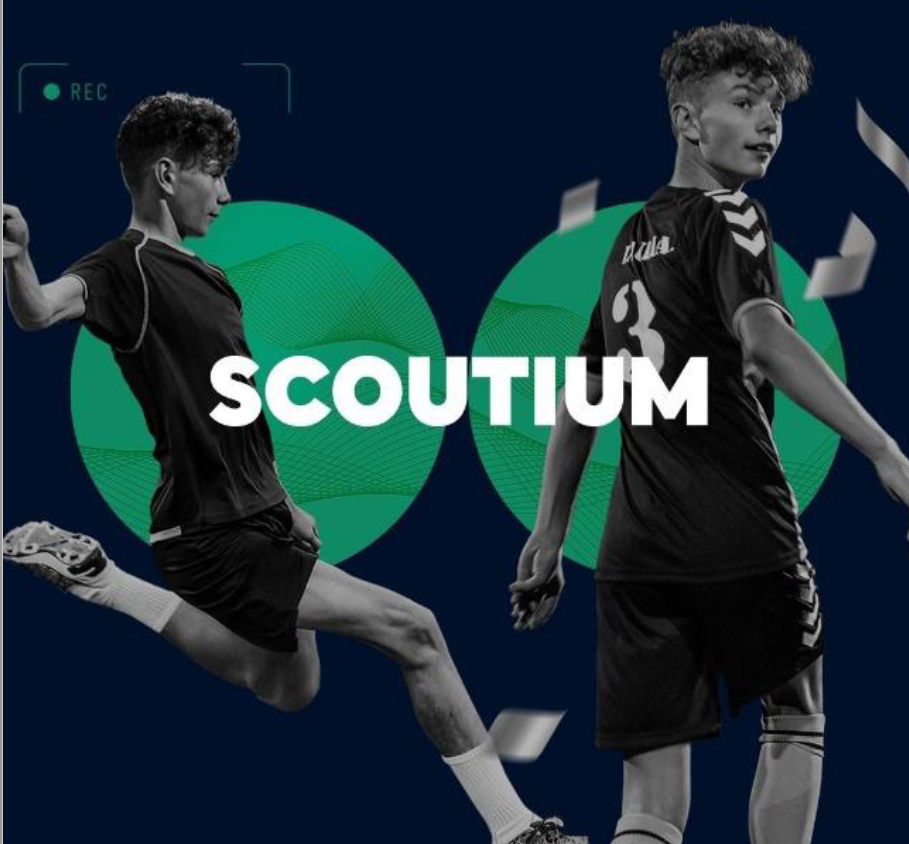

Predicting which class (average, highlighted) players are according to the scores given to the characteristics of the football players watched by the Scouts.

# <span style="color:#2D7680"> Table of Contents </span>

[<span style="color:#2D7680">   1. Examine the Dataset  </span>](#Exa)

[<span style="color:#2D7680">   2. Data Preparation  </span>](#Dat)

[<span style="color:#2D7680">   3. Feature Engineering  </span>](#Fea)

[<span style="color:#2D7680">   4. Modeling  </span>](#Mod)

[<span style="color:#2D7680">   5. Conclusion  </span>](#Con)

#  <span style="color:#2D7680"> 1. Examine the Dataset </span> <a class="anchor" id="Exa"></a> 

## scoutium_attributes.csv

**task_response_id:** The set of a scout's evaluations of all players on a team's roster in a match

**match_id:** The id of the corresponding match

**evaluator_id:** The id of the evaluator(scout)

**player_id:** The id of the respective player

**position_id:** The id of the position that the relevant player played in that match

**1:** Goalkeeper

**2:** Stopper

**3:** Right-back

**4:** Left-back

**5:** Defensive midfielder

**6:** Central midfielder

**7:** Right wing

**8:** Left wing

**9:** Attacking midfielder

**10:** Striker

**analysis_id:** Set of attribute evaluations of a scout for a player in a match

**attribute_id:** The id of each attribute that the players were evaluated for

**attribute_value:** The value (points) a scout gives to a player's attribute


## scoutium_potential_labels.csv

**task_response_id:** The set of a scout's evaluations of all players on a team's roster in a match

**match_id:** The id of the relevant match

**evaluator_id:** The id of the evaluator(scout)

**player_id:** The id of the relevant player

**potential_label:** Label that indicates the final decision of a scout regarding a player in a match. (target variable)


# <span style="color:#2D7680"> 2. Data Preparation </span> <a class="anchor" id="Dat"></a> 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, validation_curve
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Loading datasets

attributes_df = pd.read_csv("/kaggle/input/scoutiumattributes/scoutium_attributes.csv", sep=";")
potential_df = pd.read_csv("/kaggle/input/scoutiumpotentiallabels/scoutium_potential_labels.csv", sep=";")

In [3]:
attributes_df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [4]:
potential_df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [5]:
# Merge of datasets

df = attributes_df.merge(potential_df, on=["task_response_id", "match_id", "evaluator_id", "player_id"])
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


# <span style="color:#2D7680"> 3. Feature Engineering </span> <a class="anchor" id="Fea"></a> 

In [6]:
# Removing the Keeper(1) class from the dataset

df = df.loc[~(df["position_id"] == 1)]
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [7]:
df["position_id"].unique()

array([ 2, 10,  6,  5,  9,  7,  4,  3,  8])

In [8]:
df["potential_label"].unique()

array(['average', 'highlighted', 'below_average'], dtype=object)

In [9]:
# Remove the below average class in the potential label from the data set. (the below average class makes up 1% of the entire dataset)

df = df.loc[~(df["potential_label"] == "below_average")]
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value,potential_label
0,4915,62935,177676,1361061,2,12818495,4322,56.000,average
1,4915,62935,177676,1361061,2,12818495,4323,56.000,average
2,4915,62935,177676,1361061,2,12818495,4324,67.000,average
3,4915,62935,177676,1361061,2,12818495,4325,56.000,average
4,4915,62935,177676,1361061,2,12818495,4326,45.000,average


In [10]:
df["potential_label"].unique()

array(['average', 'highlighted'], dtype=object)

In [11]:
# Create a table from the dataset using the "pivot_table" function.

pivot_df = pd.pivot_table(df, values="attribute_value", index=["player_id", "position_id", "potential_label"], columns=["attribute_id"])
pivot_df.head()

attribute_id                            4322   4323   4324   4325   4326   4327   4328   4329   4330   4332   4333   4335   4338   4339   4340   4341   4342   4343   4344   4345   4348   4349   4350   4351   4352   4353   4354   4355   4356   4357   4407   4408   4423   4426
player_id position_id potential_label                                                                                                                                                                                                                                              
1355710   7           average         50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500 28.500 45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000
1356362   9           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
1356375   3           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000 56.000 56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000
          4           average         67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000
1356411   9           average         67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000 67.000 56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000

In [12]:
pivot_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 271 entries, (1355710, 7, 'average') to (1909728, 7, 'highlighted')
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4322    271 non-null    float64
 1   4323    271 non-null    float64
 2   4324    271 non-null    float64
 3   4325    271 non-null    float64
 4   4326    271 non-null    float64
 5   4327    271 non-null    float64
 6   4328    271 non-null    float64
 7   4329    271 non-null    float64
 8   4330    271 non-null    float64
 9   4332    271 non-null    float64
 10  4333    271 non-null    float64
 11  4335    271 non-null    float64
 12  4338    271 non-null    float64
 13  4339    271 non-null    float64
 14  4340    271 non-null    float64
 15  4341    271 non-null    float64
 16  4342    271 non-null    float64
 17  4343    271 non-null    float64
 18  4344    271 non-null    float64
 19  4345    271 non-null    float64
 20  4348    271 non-null    float6

In [13]:
# Using the "reset_index" function, assign the indexes as variables and convert the names of the "attribute_id" columns to strings.

pivot_df = pivot_df.reset_index()
pivot_df.columns = pivot_df.columns.astype(str)
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [14]:
pivot_df.columns

Index(['player_id', 'position_id', 'potential_label', '4322', '4323', '4324', '4325', '4326', '4327', '4328', '4329', '4330', '4332', '4333', '4335', '4338', '4339', '4340', '4341', '4342', '4343', '4344', '4345', '4348', '4349', '4350', '4351', '4352', '4353', '4354', '4355', '4356', '4357', '4407', '4408', '4423', '4426'], dtype='object', name='attribute_id')

In [15]:
# Express the “potential_label” categories (average, highlighted) numerically using the Label Encoder function.

pivot_df["potential_label"] = LabelEncoder().fit_transform(pivot_df["potential_label"])
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,0,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,0,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,0,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [16]:
# Analyzing variables 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    # 1- Categorical variables
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    # 2- Numeric but actually categorical (class)
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                        dataframe[col].dtypes != "O"]
    
    # 3 - Categorical but actually each cardinal, that is, unique
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                        dataframe[col].dtypes == "O"]
    
    # 4 - Collect the cat_cols and num_but_cat variables
    cat_cols = cat_cols + num_but_cat
    
    # 5- Subtract the cardinal variable from cat_cols
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car, num_but_cat

In [17]:
cat_cols, num_cols, cat_but_car, num_but_cat = grab_col_names(pivot_df)

Observations: 271
Variables: 37
cat_cols: 7
num_cols: 30
cat_but_car: 0
num_but_cat: 7


In [18]:
num_cols

['player_id',
 '4322',
 '4323',
 '4325',
 '4326',
 '4327',
 '4329',
 '4330',
 '4332',
 '4333',
 '4335',
 '4338',
 '4339',
 '4340',
 '4341',
 '4342',
 '4343',
 '4344',
 '4345',
 '4348',
 '4349',
 '4350',
 '4351',
 '4353',
 '4354',
 '4355',
 '4356',
 '4407',
 '4408',
 '4426']

In [19]:
num_cols.remove("player_id")

In [20]:
# Implementing StandardScaler to scale data in all "num_cols" variables you save

pivot_df[num_cols] = StandardScaler().fit_transform(pivot_df[num_cols])
pivot_df.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,0,-0.543,-0.559,34.000,-0.438,-0.767,-0.795,45.000,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,56.000,-1.282,-1.132,-0.495,-1.235,34.000,-0.143,-1.487,34.000,-0.253
1,1356362,9,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
2,1356375,3,0,0.595,0.561,67.000,0.683,0.723,0.723,67.000,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,67.000,0.814,1.053,0.632,0.915,67.000,0.530,0.669,56.000,1.042
3,1356375,4,0,0.595,1.308,67.000,0.683,0.723,1.482,78.000,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,78.000,0.814,0.428,0.632,0.198,67.000,-0.143,0.669,45.000,-0.253
4,1356411,9,0,0.595,0.561,78.000,1.430,0.723,0.723,67.000,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,67.000,0.115,0.428,0.632,0.198,67.000,1.874,-0.050,67.000,1.042


# <span style="color:#2D7680"> 4. Modelling </span> <a class="anchor" id="Mod"></a> 

In [21]:
# The data set is divided into training and testing.

X = pivot_df.drop(["potential_label", "player_id"], axis=1)
y = pivot_df["potential_label"]

In [22]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    models = [('LR', LogisticRegression()),
          ("KNN", KNeighborsClassifier()),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
          ("LightGBM", LGBMClassifier()),
          ('CatBoost', CatBoostClassifier(verbose=False))
             ]

    for name, classifier in models:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [23]:
# roc_auc scores
base_models(X, y)

Base Models....
roc_auc: 0.7995 (LR) 
roc_auc: 0.7515 (KNN) 
roc_auc: 0.7464 (CART) 
roc_auc: 0.8898 (RF) 
roc_auc: 0.8591 (GBM) 
roc_auc: 0.8443 (XGBoost) 
roc_auc: 0.8588 (LightGBM) 
roc_auc: 0.8924 (CatBoost) 


In [24]:
# f1 scores
base_models(X, y, scoring="f1")

Base Models....
f1: 0.5304 (LR) 
f1: 0.2483 (KNN) 
f1: 0.4908 (CART) 
f1: 0.5592 (RF) 
f1: 0.5836 (GBM) 
f1: 0.6086 (XGBoost) 
f1: 0.5691 (LightGBM) 
f1: 0.6066 (CatBoost) 


In [25]:
# recall scores
base_models(X, y, scoring="recall")

Base Models....
recall: 0.4279 (LR) 
recall: 0.1608 (KNN) 
recall: 0.5721 (CART) 
recall: 0.4454 (RF) 
recall: 0.5526 (GBM) 
recall: 0.5526 (XGBoost) 
recall: 0.5 (LightGBM) 
recall: 0.4805 (CatBoost) 


In [26]:
# accuracy scores
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.845 (LR) 
accuracy: 0.797 (KNN) 
accuracy: 0.8047 (CART) 
accuracy: 0.8818 (RF) 
accuracy: 0.8524 (GBM) 
accuracy: 0.8525 (XGBoost) 
accuracy: 0.845 (LightGBM) 
accuracy: 0.8744 (CatBoost) 


In [27]:
# precision scores
base_models(X, y, scoring="precision")

Base Models....
precision: 0.7242 (LR) 
precision: 0.6444 (KNN) 
precision: 0.5871 (CART) 
precision: 0.8679 (RF) 
precision: 0.7192 (GBM) 
precision: 0.699 (XGBoost) 
precision: 0.6716 (LightGBM) 
precision: 0.8524 (CatBoost) 


In [28]:
# Let's do hyperparameter optimization according to Catboost.

catboost_model = CatBoostClassifier(random_state=17, verbose=False)
catboost_params = {"iterations": [200, 500],
                   "learning_rate": [0.01, 0.1],
                   "depth": [3, 6]}
catboost_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=False).fit(X, y)
catboost_final = catboost_model.set_params(**catboost_grid.best_params_, random_state=17).fit(X, y)

In [29]:
# Final Model

cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc", "precision"])

In [30]:
# Let's look at our error metrics.

print(cv_results['test_accuracy'].mean())
print(cv_results['test_f1'].mean() )
print(cv_results['test_roc_auc'].mean())
print(cv_results['test_precision'].mean() )

0.8930639730639731
0.6860566448801743
0.8938336856941509
0.8933333333333333


In [31]:
# Let's plot the order of the features using the feature_importance function that shows the importance of the variables

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

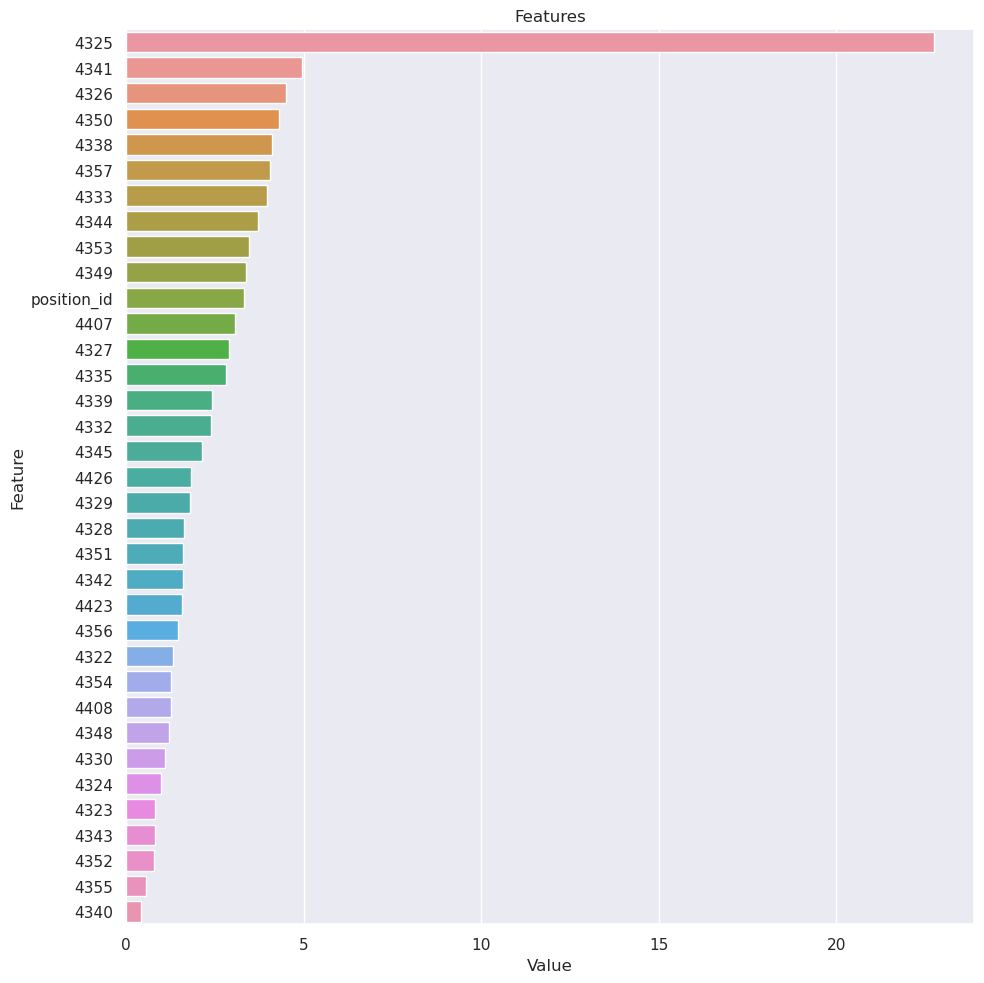

In [32]:
plot_importance(catboost_final, X)

#  <span style="color:#2D7680"> 5. Conclusion </span> <a class="anchor" id="Con"></a> 

Among these data, XGBoost and Catboost algorithms have the highest accuracy. In a situation where less emphasis is placed on training time, these algorithms may be a better option. Variable 4325 is the most effective variable.